In [1]:
%matplotlib inline 

# Building a Classifier from Cenus Data
**An end-to-end machine learning example using Pandas and Scikit-Learn** 

One of the machine learning workshops given to students in the [Georgetown Data Science Certificate](http://scs.georgetown.edu/programs/375/data-science/) is to build a classification, regression, or clustering model using one of the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html) datasets. The idea behind the workshop is to ingest data from a website, perform some initial analyses to get a sense for what's in the data, then structure the data to fit a Scikit-Learn model and evaluate the results. Although the repository does give advice as to what types of machine learning might be applied, this workshop still poses a challenge, especially in terms of data wrangling. 

In this post, I'll outline how I completed this workshop alongside my students this past weekend. For those new to machine learning or to Scikit-Learn, I hope this is a practical example that may shed light on many challenges that crop up developing predictive models. For more experienced readers, I hope that I can challenge you to try this workshop, and to contribute iPython notebooks with your efforts as tutorials! 

## Data Ingestion

The first part of the workshop is to use the UCI Machine Learning Repository to find a non-trivial dataset with which to build a model. While the example datasets included with Scikit-Learn are good examples of how to fit models, they do tend to be either trivial or overused. By exploring a novel dataset with several (more than 10) features and many instances (more than 10,000), I was hoping to conduct a predictive exercise that could show a bit more of a challenge. 

There are around 350 datasets in the repository, categorized by things like task, attribute type, data type, area, or number of attributes or instances. I ended up choosing a [Census Income](http://archive.ics.uci.edu/ml/datasets/Census+Income) dataset that had 14 attributes and 48,842 instances. The task listed was a binary classifier to build a model that could determine from census information whether or not the person made more than $50k per year. 

Every dataset in the repository comes with a link to the data folder, which I simply clicked and downloaded to my computer. However, in an effort to make it easier for you to follow along, I've included a simple `download_data` function that uses `requests.py` to fetch the data. 

In [5]:
import os 
import requests 

CENSUS_DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names", 
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", 
)

def download_data(path='data', urls=CENSUS_DATASET):
    if not os.path.exists(path):
        os.mkdir(path) 
    
    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url) 
        with open(os.path.join(path, name), 'w') as f: 
            f.write(response.content)

download_data()

This code also helps us start to think about how we're going to manage our data on disk. I've created a `data` folder in my current working directory to hold the data as it's downloaded. In the data management section, we'll expand this folder a bit further to be loaded as a `Bunch` object. 

## Data Exploration 

The very first thing to do is to explore the dataset and see what's inside. The three files that downloaded do not have a file extension, but they are simply text files. You can change the extension to `.txt` for easier exploration if that helps. By using the `head` and `wc -l` commands on the command line, our files appear to be as follows: 

- `adult.data`: A CSV dataset containing 32,562 rows and no header
- `adult.names`: A text file containing meta information about the dataset 
- `adult.test`: A CSV dataset containing 16,283 rows with a weird first line 

Clearly this dataset is intended to be used for machine learning, and a test and training data set has already been constructed. Similar types of split datasets are used for [Kaggle](https://www.kaggle.com/) competitions and academic conferences. This will save us a step when it comes to evaluation time. 

Since we already have a csv file, let's explore the dataset using Pandas: 

In [77]:
import pandas as pd 
import seaborn as sns

names = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
]

data = pd.read_csv('data/adult.data', names=names)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Because the CSV data doesn't have a header row, I had to supply the names directly to the `pd.read_csv` function. To get these names, I manually constructed the list by reading the `adult.names` file. In the future, we'll store these names as a machine readable JSON file so that we don't have to manuually construct it. 

By glancing at the first 5 rows of the data, we can see that we have primarily categorical data. Our target, `data.income` is also currently constructed as a categorical field. Unfortunately, with categorical fields, we don't have a lot of visualization options (quite yet). However, it would be interesting to see the frequencies of each class, relative to the target of our classifier. To do this, we can use Seaborn's `countplot` function to count the occurrences of each data point. Let's take a look at the counts of `data.occupation` and `data.education` &mdash; two likely predictors of income in the census data:

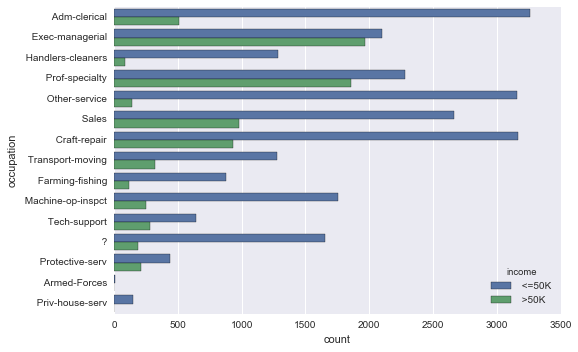

In [78]:
sns.countplot(y='occupation', hue='income', data=data,)

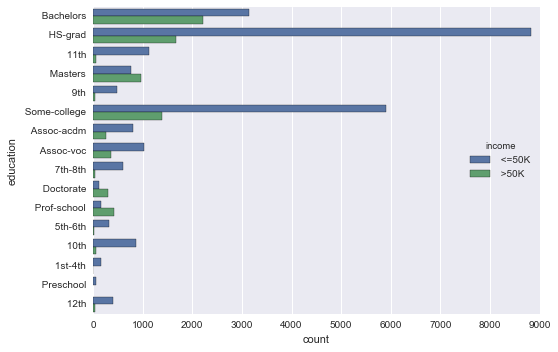

In [79]:
sns.countplot(y='education', hue='income', data=data,)

The `countplot` function accepts either an `x` or a `y` argument to specify if this is a bar plot or a column plot. I chose to use the `y` argument so that the labels were readable. The `hue` argument specifies a column for comparison; in this case we're concerned with the relationship of our categorical variables to the target income. Go ahead and explore other variables in the dataset, for example `data.race` and `data.sex` to see if those values are predictive of the level of income or not!

## Data Management 

Now that we've completed some initial investigation and have started to identify the possible feautures available in our dataset, we need to structure our data on disk in a way that we can load into Scikit-Learn in a repeatable fashion for continued analysis. My proposal is to use the `sklearn.datasets.base.Bunch` object to load the data into `data` and `target` attributes respectively, similar to how Scikit-Learn's toy datasets are structured. Using this object to manage our data will mirror the native API and allow us to easily copy and paste code that demonstrates classifiers and technqiues with the built in datasets. Importantly, this API will also allow us to communicate to other developers and our future-selves exactly how to use the data. 

In order to organize our data on disk, we'll need to add the following files:

- `README.md`: a markdown file containing information about the dataset and attribution. Will be exposed by the `DESCR` attribute.
- `meta.json`: a helper file that contains machine readable information about the dataset like `target_names` and `feature_names`.

I constructed a pretty simple `README.md` in Markdown that gave the title of the dataset, the link to the UCI Machine Learning Repository page that contained the dataset, as well as a citation to the author. I simply wrote this file directly using my own text editor. 

The `meta.json` file, however, we can write using the data frame that we already have. We've already done the manual work of writing the column names into a `names` variable earlier, there's no point in letting that go to waste! 

In [80]:
import json 


meta = {
    'target_names': list(data.income.unique()),
    'feature_names': list(data.columns),
    'categorical_features': {
        column: list(data[column].unique())
        for column in data.columns
        if data[column].dtype == 'object'
    },
}

with open('data/meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

This code creates a `meta.json` file by inspecting the data frame that we have constructued. The `target_names` column, is just the two unique values in the `data.income` series; by using the `pd.Series.unique` method - we're guarenteed to spot data errors if there are more or less than two values. The `feature_names` is simply the names of all the columns. 

Then we get tricky &mdash; we want to store the possible values of each categorical field for lookup later, but how do we know which columns are categorical and which are not? Luckily, Pandas has already done an analysis for us, and has stored the column data type, `data[column].dtype`, as either `int64` or `object`. Here I am using a dictionary comprehension to create a dictionary whose keys are the categorical columns, determined by checking the object type and comparing with `object`, and whose values are a list of unique values for that field. 

Now that we have everything we need stored on disk, we can create a `load_data` function, which will allow us to load the training and test datasets appropriately from disk and store them in a `Bunch`: 

In [86]:
from sklearn.datasets.base import Bunch

def load_data(root='data'):
    # Load the meta data from the file 
    with open(os.path.join(root, 'meta.json'), 'r') as f:
        meta = json.load(f) 
    
    names = meta['feature_names']
    
    # Load the readme information 
    with open(os.path.join(root, 'README.md'), 'r') as f:
        readme = f.read() 
    
    # Load the training and test data, skipping the bad row in the test data 
    train = pd.read_csv(os.path.join(root, 'adult.data'), names=names)
    test  = pd.read_csv(os.path.join(root, 'adult.test'), names=names, skiprows=1)
    
    # Remove the target from the categorical features 
    meta['categorical_features'].pop('income')
    
    # Return the bunch with the appropriate data chunked apart
    return Bunch(
        data = train[names[:-1]], 
        target = train[names[-1]], 
        data_test = test[names[:-1]], 
        target_test = test[names[-1]], 
        target_names = meta['target_names'],
        feature_names = meta['feature_names'], 
        categorical_features = meta['categorical_features'], 
        DESCR = readme,
    )

dataset = load_data()

The primary work of the `load_data` function is to locate the appropriate files on disk, given a root directory that's passed in as an argument (if you saved your data in a different directory, you can modify the root to have it look in the right place). The meta data is included with the bunch, and is also used split the train and test datasets into `data` and `target` variables appropriately, such that we can pass them correctly to the Scikit-Learn `fit` and `predict` estimator methods. 

## Feature Extraction 

Now that our data management workflow is structured a bit more like Scikit-Learn, we can start to use our data to fit models. Unfortunately, the categorical values themselves are not useful for machine learning; we need a single instance table that contains _numeric values_. In order to extract this from the dataset, we'll have to use Scikit-Learn transformers to transform our input dataset into something that can be fit to a model. In particular, we'll have to do the following:

- encode the categorical labels as numeric data 
- impute missing values with data (or remove)

We will explore how to apply these transformations to our dataset, then we will create a feature extraction pipeline that we can use to build a model from the raw input data. This pipeline will apply both the imputer and the label encoders directly in front of our classifier, so that we can ensure that features are extracted appropriately in both the training and test datasets.  

### Label Encoding 

Our first step is to get our data out of the object data type land and into a numeric type, since nearly all operations we'd like to apply to our data are going to rely on numeric types. Luckily, Sckit-Learn does provide a transformer for converting categorical labels into numeric integers: [`sklearn.preprocessing.LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Unfortunately it can only transform a single vector at a time, so we'll have to adapt it in order to apply it to multiple columns. 

Like all Scikit-Learn transformers, the `LabelEncoder` has `fit` and `transform` methods (as well as a special all-in-one, `fit_transform` method) that can be used for stateful transformation of a dataset. In the case of the `LabelEncoder`, the `fit` method discovers all unique elements in the given vector, orders them lexicographically, and assigns them an integer value. These values are actually the indices of the elements inside the `LabelEncoder.classes_` attribute, which can also be used to do a reverse lookup of the class name from the integer value. 

For example, if we were to encode the `gender` column of our dataset as follows:

In [82]:
from sklearn.preprocessing import LabelEncoder 

gender = LabelEncoder() 
gender.fit(dataset.data.sex)
print(gender.classes_)

[' Female' ' Male']


We can then transform a single vector into a numeric vector as follows:

In [83]:
print(gender.transform([
    ' Female', ' Female', ' Male', ' Female', ' Male'
]))

[0 0 1 0 1]


Obviously this is very useful for a single column, and in fact the `LabelEncoder` really was intended to encode the target variable, not necessarily categorical data expected by the classifiers.

**Note:** Unfortunately, it was at this point that I realized the values all had a space in front of them. I'll address what I might have done about this in the conclusion. 

In order to create a multicolumn LabelEncoder, we'll have to extend the `TransformerMixin` in Scikit-Learn to create a transformer class of our own, then provide `fit` and `transform` methods that wrap individual `LabelEncoders` for our columns. My code, inspired by the StackOverflow post &ldquo;[Label encoding across multiple columns in scikit-learn](http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn)&rdquo;, is as follows:

In [107]:
from sklearn.base import BaseEstimator, TransformerMixin

class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns  = columns 
        self.encoders = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns 
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        
        return output

encoder = EncodeCategorical(dataset.categorical_features.keys())
data = encoder.fit_transform(dataset.data)

This specialized transformer now has the ability to label encode multiple columns in a data frame, saving information about the state of the encoders. It would be trivial to add an `inverse_transform` method that accepts numeric data and converts it to labels, using the `inverse_transform` method of each individual `LabelEncoder` on a per-column basis. 

### Imputation 

According to the `adult.names` file, unknown values are given via the `"?"` string. We'll have to either ignore rows that contain a `"?"` or impute their value to the row. Scikit-Learn provides a transformer for dealing with missing values at either the column level or at the row level in the `sklearn.preprocessing` library called the [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html).

The `Imputer` requires information about what missing values are, either an integer or the string, `Nan` for `np.nan` data types, it then requires a strategy for dealing with it. For example, the `Imputer` can fill in the missing values with the mean, median, or most frequent values for each column. If provided an axis argument of 0 then columns that contain only missing data are discarded; if provided an axis argument of 1, then rows which contain only missing values raise an exception. Basic usage of the `Imputer` is as follows:

```python
imputer = Imputer(missing_values='Nan', strategy='most_frequent')
imputer.fit(dataset.data)
```

Unfortunately, this would not work for our label encoded data, because 0 is an acceptable label &mdash; unless we could guarentee that 0 was always `"?"`, then this would break our numeric columns that already had zeros in them. This is certainly a challenging problem, and unfortunately the best we can do, is to once again create a custom Imputer. 

In [108]:
from sklearn.preprocessing import Imputer 

class ImputeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns = columns 
        self.imputer = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to impute. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit an imputer for each column in the data frame
        self.imputer = Imputer(missing_values=0, strategy='most_frequent')
        self.imputer.fit(data[self.columns])

        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        output[self.columns] = self.imputer.transform(output[self.columns])
        
        return output

    
imputer = ImputeCategorical(['workclass', 'native-country', 'occupation'])
data = imputer.fit_transform(data)

Our custom imputer, like the `EncodeCategorical` transformer takes a set of columns to perform imputation on. In this case we only wrap a single `Imputer` as the `Imputer` is multicolumn &mdash; all that's required is to ensure that the correct columns are transformed. I inspected the encoders and found only three columns that had missing values in them, and passed them directly into the customer imputer. 

I had chosen to do the label encoding first, assuming that because the `Imputer` required numeric values, I'd be able to do the parsing in advance. However, after requiring a custom imputer, I'd say that it's probably best to deal with the missing values early, when they're still a specific value, rather than take a chance. 

## Model Build 

Now that we've finally acheived our feature extraction, we can continue on to the model build phase. To create our classifier, we're going to create a [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that uses our feature transformers and ends in an estimator that can do classification. We can then write the entire pipeline object to disk with the `pickle`, allowing us to load it up and use it to make predictions in the future. 

A pipeline is a step-by-step set of transformers that takes input data and transforms it, until finally passing it to an estimator at the end. Pipelines can be constructed using a named declarative syntax so that they're easy to modify and develop. Our pipeline is as follows:

In [110]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# we need to encode our target data as well. 
yencode = LabelEncoder().fit(dataset.target)

# construct the pipeline 
census = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('imputer', ImputeCategorical(['workclass', 'native-country', 'occupation'])), 
        ('classifier', LogisticRegression())
    ])

# fit the pipeline 
census.fit(dataset.data, yencode.transform(dataset.target))

Pipeline(steps=[('encoder', EncodeCategorical(columns=[u'workclass', u'relationship', u'sex', u'race', u'native-country', u'education', u'marital-status', u'occupation'])), ('imputer', ImputeCategorical(columns=['workclass', 'native-country', 'occupation'])), ('classifier', LogisticRegression(C=1.0, class_we...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

The pipeline first passes data through our encoder, then to the imputer, and finally to our classifier. In this case, I have chosen a `LogisticRegression`, a regularized linear model that is used to estimate a categorical dependent variable, much like the binary target we have in this case. We can then evaluate the model on the test data set using the same exact pipeline. 

In [118]:
from sklearn.metrics import classification_report 

# encode test targets, and strip traililng '.' 
y_true = yencode.transform([y.rstrip(".") for y in dataset.target_test])

# use the model to get the predicted value
y_pred = census.predict(dataset.data_test)

# execute classification report 
print classification_report(y_true, y_pred, target_names=dataset.target_names)

             precision    recall  f1-score   support

      <=50K       0.81      0.96      0.88     12435
       >50K       0.67      0.29      0.40      3846

avg / total       0.78      0.80      0.77     16281



As part of the process in encoding the target for the test data, I discovered that the classes in the test data set had a `"."` appended to the end of the class name, which I had to strip in order for the encoder to work! However, once done, I could predict the y values using the test dataset, passing the predicted and true values to the classifier report. 

The classifier I built does an ok job, with an F1 score of 0.77, nothing to sneer at. However, it is possible that an SVM, a Naive Bayes, or a k nearest neighbor model would do better. It is easy to construct new models using the pipeline approach that we prepared before, and I would encourage you to try it out! Furthermore, a grid search or feature analysis may lead to a higher scoring model than the one we quickly put together. Luckily, now that we've sorted out all the pipeline issues, we can get to work on inspecting and improving the model! 

The last step is to save our model to disk for reuse later, with the `pickle` module:

In [119]:
import pickle 

def dump_model(model, path='data', name='classifier.pickle'):
    with open(os.path.join(path, name), 'wb') as f:
        pickle.dump(model, f)
        
dump_model(census)

You should also dump meta information about the date and time your model was built, who built the model, etc. But we'll skip that step here, since this post serves as a guide. 

## Model Operation 

Now it's time to explore how to use the model. To do this, we'll create a simple function that gathers input from the user on the command line, and returns a prediction with the classifier model. Moreover, this function will load the pickled model into memory to ensure the latest and greatest saved model is what's being used. 

In [175]:
def load_model(path='data/classifier.pickle'):
    with open(path, 'rb') as f:
        return pickle.load(f) 


def predict(model, meta=meta):
    data = {} # Store the input from the user
    
    for column in meta['feature_names'][:-1]:
        # Get the valid responses
        valid = meta['categorical_features'].get(column)
    
        # Prompt the user for an answer until good 
        while True:
            val = " " + raw_input("enter {} >".format(column))
            if valid and val not in valid:
                print "Not valid, choose one of {}".format(valid)
            else:
                data[column] = val
                break
    
    # Create prediction and label 
    yhat = model.predict(pd.DataFrame([data]))
    return yencode.inverse_transform(yhat)
            
    
# Execute the interface 
model = load_model()
predict(model)

enter age >52
enter workclass >Self-emp-not-inc
enter fnlwgt >209642
enter education >HS-grad
enter education-num >9
enter marital-status >Married-civ-spouse
enter occupation >Exec-managerial
enter relationship >Husband
enter race >White
enter sex >Male
enter capital-gain >0
enter capital-loss >0
enter hours-per-week >45
enter native-country >United-States


array([' <=50K'], dtype=object)

The hardest part about operationalizing the model is collecting user input. Obviously in a bigger application this could be handled with forms, automatic data gathering, and other advanced techniques. For now, hopefully this is enough to highlight how you might use the model in practice to make predictions on unknown data. 

## Conclusion 

This walkthrough was an end-to-end look at how I performed a classification analysis of a dataset that I downloaded from the Internet. I tried to stay true to my exact workflow so that you could get a sense for how I had to go about doing things with little to no advanced knowledge. As a result, there are definitely some things I might change if I was going to do this over. 

One place that I struggled with was trying to decide if I should write out wrangled data back to disk, then load it again, or if I should maintain a feature extraction of the raw data. I kept going back and forth, particularly because of silly things like the spaces in front of the values. This could be fixed by loading the data as follows:

```python
pd.read_csv('adult.data', sep="\s*,", names=names)
```

Using a regular expression for the seperator that would automatically strip whitespace. However, I'd already gone too far to make these changes!

I also had problems with the ordering of the label encoding and the imputation. Given another chance, I think I would definitely wrangle and clean both datasets and save them back to disk. Even just little things like the "." at the end of the class names in the test set were annoyances that could have been easily dealt with. 

Now that you've had a chance to look at my walkthrough, I hope you'll try a few on your own and send your workflows and analyses to us so that we can post them as well! 